## Gensim Embedding Classifier

Load required packages:

In [0]:
import pandas as pd
import gensim
import re
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
%matplotlib inline

Load data:

In [0]:
logs_labels = pd.read_csv("logs_labels.csv")

test_split = int(.75*len(logs_labels.full_log))
full_logs = logs_labels.full_log
levels = logs_labels.label

Manual regular expressions-based tokenizer:

In [0]:
def extract_tokens(string):
    tokens = []
    line = str(string)
    r = re.compile(r"^\[([\w:/]+\s[+\-]\d{4})\] (\S+)\s?(\S+)?\s?(\S+)? (\d{3}|-) (\d+|-) (\S*) (.+)$")
    result = r.split(line)
    for r in range(len(result)):
        if r in [0,1,4,6,8,9]:
            continue
        if r in [2,5]:
            tokens.append(result[r])
        else:
            if result[r] == "-":
                tokens.append(result[r])
            else:
                for i in re.findall(r"[a-zA-Z_']+", result[r]):
                    tokens.append(i)
    return tokens

In [0]:
logs = []
for line in full_logs:
    tokens = extract_tokens(line)
    logs.append(tokens)

Extract binary labels:

In [0]:
labels = [0 if i == 0 else 1 for i in levels]

Compute token statistics:

In [0]:
tokens = []

for i in logs:
    for j in i:
        tokens.append(j)
    
unique_tokens = (len(set(tokens)))
max_doc_len = max([len(i) for i in logs])
min_doc_len = min([len(i) for i in logs])

print("Unique tokens:", unique_tokens)
print("Longest document:", max_doc_len, "tokens")
print("Shortest document:", min_doc_len, "tokens")

Unique tokens: 11364
Longest document: 587 tokens
Shortest document: 2 tokens


Split data for testing purposes, train model and save configuration:

In [0]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(logs)]

X_train = documents[:test_split]
X_val = documents[test_split:]
y_train = labels[:test_split]
y_val = labels[test_split:]

model = Doc2Vec(X_train, vector_size=100, window=5, min_count=1, epochs = 30)

model.save("model.model")

Get trained vectors and infer vectors from unseen documents:

In [0]:
train_vectors = []
for i in range(len(model.docvecs)):
    train_vectors.append(model.docvecs[i])
    
val_vectors = []
for d in X_val:
    val_vectors.append(model.infer_vector(d[0]))  

Split data from zero and non-zero classes for One-Class SVM, transform labels to be 1 and -1, and fit classifier:

In [0]:
train_zero = []
train_one = []

for i, label in enumerate(y_train):
    if label == 0:
        train_zero.append(train_vectors[i])
    if label == 1:
        train_one.append(train_vectors[i])
        
one_class_test_label = [1 if i == 0 else -1 for i in y_val]        

In [0]:
clf = svm.OneClassSVM(max_iter = 2000, verbose = 2)
clf.fit(train_zero)

Make predictions and evaluate:

In [0]:
y_pred = clf.predict(val_vectors)
classification_report(one_class_test_label, y_pred))

             precision    recall  f1-score   support

         -1       0.24      0.98      0.38      9281
          1       0.99      0.38      0.55     47679

avg / total       0.87      0.48      0.52     56960



Train decision tree and evaluate:

In [0]:
dtc = DecisionTreeClassifier(max_depth = 15)
dtc.fit(train_vectors, y_train)

y_pred = dtc.predict(val_vectors)
print(classification_report(y_val, y_pred))

             precision    recall  f1-score   support

          0       0.83      0.93      0.88     47679
          1       0.12      0.05      0.07      9281

avg / total       0.72      0.78      0.75     56960


Loop through some MLP configurations and evaluate:

In [0]:
for i in [(50), (100,), (50,50), (100,100), (200,200)]:
    mlp = MLPClassifier(hidden_layer_sizes = i, solver = "adam", max_iter = 300, verbose = 0)

    mlp.fit(train_vectors, y_train)

    y_pred = mlp.predict(val_vectors)
    print("Scores with hidden layers", str(i))
    print(classification_report(y_val, y_pred))

Scores with hidden layers 50
             precision    recall  f1-score   support

          0       0.85      0.99      0.91     47679
          1       0.64      0.07      0.13      9281

avg / total       0.81      0.84      0.79     56960

Scores with hidden layers (100,)
             precision    recall  f1-score   support

          0       0.85      0.99      0.91     47679
          1       0.70      0.08      0.14      9281

avg / total       0.82      0.84      0.79     56960

Scores with hidden layers (50, 50)
             precision    recall  f1-score   support

          0       0.85      0.99      0.91     47679
          1       0.51      0.08      0.13      9281

avg / total       0.79      0.84      0.78     56960

Scores with hidden layers (100, 100)
             precision    recall  f1-score   support

          0       0.85      0.99      0.91     47679
          1       0.59      0.08      0.14      9281

avg / total       0.80      0.84      0.79     56960

Scores

In [0]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

for i in [(50), (100,), (50,50), (100,100), (200,200)]:
    mlp = MLPClassifier(hidden_layer_sizes = i, solver = "adam", max_iter = 300, verbose = 0)

    mlp.fit(train_vectors, y_train)

    y_pred = mlp.predict(val_vectors)
    print("Scores with hidden layers", str(i))
    print(classification_report(y_val, y_pred))

Scores with hidden layers 50
             precision    recall  f1-score   support

          0       0.85      0.99      0.91     47679
          1       0.64      0.07      0.13      9281

avg / total       0.81      0.84      0.79     56960

Scores with hidden layers (100,)
             precision    recall  f1-score   support

          0       0.85      0.99      0.91     47679
          1       0.70      0.08      0.14      9281

avg / total       0.82      0.84      0.79     56960

Scores with hidden layers (50, 50)
             precision    recall  f1-score   support

          0       0.85      0.99      0.91     47679
          1       0.51      0.08      0.13      9281

avg / total       0.79      0.84      0.78     56960

Scores with hidden layers (100, 100)
             precision    recall  f1-score   support

          0       0.85      0.99      0.91     47679
          1       0.59      0.08      0.14      9281

avg / total       0.80      0.84      0.79     56960

Scores

In [0]:
mlp = MLPClassifier(hidden_layer_sizes = (1000,400), solver = "adam", max_iter = 300, verbose = 2)

mlp.fit(train_vectors, y_train)

y_pred = mlp.predict(val_vectors)
print("Scores with hidden layers", str(i))
print(classification_report(y_val, y_pred))

Iteration 1, loss = 0.13971561
Iteration 2, loss = 0.07826474
Iteration 3, loss = 0.06539030
Iteration 4, loss = 0.05549558
Iteration 5, loss = 0.04900233
Iteration 6, loss = 0.04407643
Iteration 7, loss = 0.04028370
Iteration 8, loss = 0.03647316
Iteration 9, loss = 0.03414435
Iteration 10, loss = 0.03024484
Iteration 11, loss = 0.02922733
Iteration 12, loss = 0.02742626
Iteration 13, loss = 0.02513969
Iteration 14, loss = 0.02369647
Iteration 15, loss = 0.02224072
Iteration 16, loss = 0.02120726
Iteration 17, loss = 0.02037840
Iteration 18, loss = 0.01916402
Iteration 19, loss = 0.01905142
Iteration 20, loss = 0.01771754
Iteration 21, loss = 0.01743629
Iteration 22, loss = 0.01622147
Iteration 23, loss = 0.01578109
Iteration 24, loss = 0.01552527
Iteration 25, loss = 0.01366711
Iteration 26, loss = 0.01443225
Iteration 27, loss = 0.01349856
Iteration 28, loss = 0.01362918
Iteration 29, loss = 0.01206543
Iteration 30, loss = 0.01594384
Iteration 31, loss = 0.01197510
Iteration 32, los

Since the configuration with (200,200) neurons performs best, plot ROC curve for that configuration:

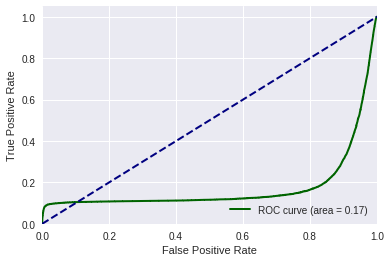

In [0]:
mlp = MLPClassifier(hidden_layer_sizes = (200,200), solver = "adam", max_iter = 300, verbose = 2)
mlp.fit(train_vectors, y_train)

probs = mlp.predict_proba(val_vectors)
preds = probs[:,1]

fpr, tpr, thresholds = roc_curve(y_val, preds, pos_label = 1)
roc_auc = auc(fpr,tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkgreen',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()